In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

# CI long

In [8]:
def confidence_interval(sample, distribution='t', confidence_level=0.95, std_general=None):
    """
    Функція для розрахунку довірчого інтервалу для середнього значення вибірки 
    з використанням t-розподілу чи нормального розподілу.

    Параметри:
    sample (array-like): Вибірка для аналізу.

    distribution (str, optional): Тип розподілу для використання у розрахунках. 
    Може бути 't' для t-розподілу Стьюдента чи 'z' для нормального розподілу. За замовчуванням 't'.

    confidence_level (float, optional): Рівень довіри для інтервалу. За замовчуванням 0.95.

    std_general (float, optional): Відоме стандартне відхилення генеральної сукупності.

    Повертає:
    tuple: Довірчий інтервал у формі (нижня межа, верхня межа).

    Використання розподілів:
    - 't' (t-розподіл Стьюдента) рекомендується використовувати, 
    коли розмір вибірки є малим (зазвичай менше 30) чи коли стандартне відхилення генеральної сукупності невідоме.

    - 'z' (нормальний розподіл) рекомендується використовувати для великих вибірок (30 чи більше), 
    де застосовна центральна гранична теорема, що дозволяє припустити, що розподіл середніх значень вибірки є нормальним.
    """
    mean = np.mean(sample)
    std_dev = np.std(sample, ddof=1) if std_general is None else std_general
    n = len(sample)
    alpha = 1 - confidence_level

    if distribution == 't':
        degrees_of_freedom = n - 1
        critical_value = stats.t.ppf(1 - alpha / 2, degrees_of_freedom)
    elif distribution == 'z':
        critical_value = stats.norm.ppf(1 - alpha / 2)
    else:
        raise ValueError("Невідомий тип розподілу. Використовуйте 't' або 'z'.")

    margin_of_error = critical_value * (std_dev / np.sqrt(n))
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)

    return confidence_interval

Припустимо, ви аналізуєте дані про тривалість сну у вибірці з 50 людей. Ваша вибірка має середню тривалість сну 7.5 годин і стандартне відхилення 1.2 години.

In [9]:
np.random.seed(42)
sample = np.random.normal(loc=7.5, scale=1.2, size=50)

In [10]:
confidence_interval = confidence_interval(sample, distribution='t', confidence_level=0.95, std_general=1.2)
print(f"Довірчий інтервал для середньої: {confidence_interval}")

Довірчий інтервал для середньої: (6.888395087545784, 7.57046753983948)


Отже, 95% довірчий інтервал для тривалості сну буде від 6.88 до 7.57 годин. Це означає, що з ймовірністю 95% справжня середня тривалість сну у популяції буде в межах цього інтервалу.

# баєсовський довірчий інтервал

In [11]:
stats.bayes_mvs(sample, alpha=0.95)

(Mean(statistic=7.229431313692632, minmax=(6.911016435848091, 7.547846191537173)),
 Variance(statistic=1.3087189476426353, minmax=(0.8759281747132203, 1.949293404467623)),
 Std_dev(statistic=1.1379240917430835, minmax=(0.9359103454461971, 1.396170979668186)))

# частотний CI через bootstrap

In [12]:
res = stats.bootstrap((sample,), np.mean, confidence_level=0.95)
res.confidence_interval

ConfidenceInterval(low=6.923487801132801, high=7.541383112725366)

# PDF & CDF

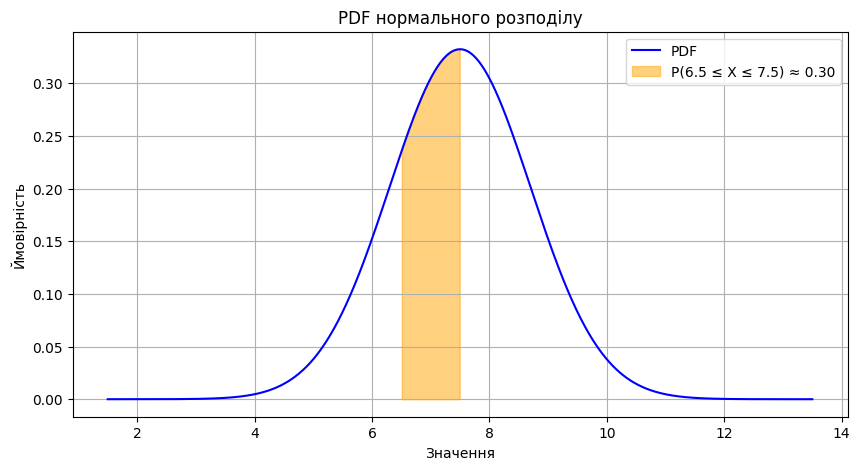

0.29812017379959843

In [13]:
def normal_distribution_analysis(mu, sigma, a=None, b=None, num_points=1000, plot=False):
    """
    Універсальна функція для аналізу нормального розподілу.
    
    Параметри:
    - mu, sigma: середнє та стандартне відхилення
    - a, b: межі проміжку для ймовірності (опціонально)
    - num_points: кількість точок для побудови PDF/CDF
    - plot: чи будувати графік PDF (True/False)
    
    Повертає:
    - pdf: значення PDF на сітці
    - cdf: значення CDF на сітці
    - x: сітка значень
    - prob: ймовірність потрапити в [a,b] (None, якщо a або b не вказані)
    """
    # Сітка значень
    x = np.linspace(mu - 5*sigma, mu + 5*sigma, num_points)
    dx = x[1] - x[0]
    
    # PDF
    pdf = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
    
    # CDF чисельно
    cdf = np.cumsum(pdf) * dx
    
    # Ймовірність потрапити в [a,b]
    prob = None
    if a is not None and b is not None:
        i_a = np.searchsorted(x, a)
        i_b = np.searchsorted(x, b)
        prob = cdf[i_b] - cdf[i_a]
    
    # Побудова графіка PDF
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(x, pdf, label='PDF', color='blue')
        if prob is not None:
            plt.fill_between(x[i_a:i_b], pdf[i_a:i_b], color='orange', alpha=0.5,
                             label=f'P({a} ≤ X ≤ {b}) ≈ {prob:.2f}')
        plt.xlabel('Значення')
        plt.ylabel('Ймовірність')
        plt.title('PDF нормального розподілу')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return pdf, cdf, x, prob

pdf, cdf, x, prob = normal_distribution_analysis(mu=7.5, sigma=1.2, a=6.5, b=7.5, plot=True)
prob

Отже, існує 30% ймовірність що тривалість сну конкретної людини буде в межах між 6.5 та 7.5 годинами

# CI discrete

In [14]:
def binomial_confidence_interval(successes, n, method='clopper-pearson', confidence_level=0.95):
    """
    Розрахунок довірчого інтервалу для біноміальної пропорції.

    Параметри:
    successes (int): Кількість успіхів.
    n (int): Загальна кількість спроб.
    method (str, optional): Метод розрахунку. 'wald' для нормального наближення, 
                            'clopper-pearson' для точного біноміального інтервалу. За замовчуванням 'clopper-pearson'.
    confidence_level (float, optional): Рівень довіри. За замовчуванням 0.95.

    Повертає:
    tuple: (нижня межа, верхня межа) пропорції успіхів.
    """
    p_hat = successes / n
    alpha = 1 - confidence_level

    if method == 'wald':
        # нормальне наближення (Wald)
        z = stats.norm.ppf(1 - alpha / 2)
        se = np.sqrt(p_hat * (1 - p_hat) / n)
        lower = p_hat - z * se
        upper = p_hat + z * se
        # обрізати межі до [0, 1]
        lower = max(0, lower)
        upper = min(1, upper)

    elif method == 'clopper-pearson':
        # точний біноміальний інтервал
        lower = stats.beta.ppf(alpha / 2, successes, n - successes + 1) if successes > 0 else 0.0
        upper = stats.beta.ppf(1 - alpha / 2, successes + 1, n - successes) if successes < n else 1.0

    else:
        raise ValueError("Невідомий метод. Використовуйте 'wald' або 'clopper-pearson'.")

    return (lower, upper)


In [15]:
binomial_confidence_interval(30, 100, method='wald')
binomial_confidence_interval(30, 100, method='clopper-pearson')

(0.21240642048953665, 0.3998146761798041)

Ми на 95% впевнені, що справжня ймовірність успіху в генеральній сукупності лежить між 21.2% та 39.7%.